# Carica i dati

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().set("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.3.2")
sc = SparkContext(conf=conf)

spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/MPST.plots") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/MPST.plots") \
    .getOrCreate()

plots_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
plots_df.show()

+---------+--------------------+--------------------+
|      _id|       plot_synopsis|               title|
+---------+--------------------+--------------------+
|tt0000091|The film opens wi...| Le manoir du diable|
|tt0000225|A widower merchan...| La belle et la bête|
|tt0000230|A prologue in fro...|          Cendrillon|
|tt0000417|At a meeting of t...|Le voyage dans la...|
|tt0000488|Joe is an impover...|The Land Beyond t...|
|tt0000634|Mark Antony – one...|Antony and Cleopatra|
|tt0000709|The play opens wi...|       Julius Caesar|
|tt0000966|The play consists...|A Midsummer Night...|
|tt0001223|The film starts w...|        Frankenstein|
|tt0001227|Dr. Richard Kimbl...|        The Fugitive|
|tt0001724|Two men who are f...|The Last Drop of ...|
|tt0001915|=== Book the Firs...|A Tale of Two Cities|
|tt0002130|The exhumation of...|           L'Inferno|
|tt0003419|Being praised as ...|Der Student von Prag|
|tt0003489|In Pompeii 79AD, ...|Gli ultimi giorni...|
|tt0004022|The play opens wi

# Divisione training-test e pulizia degli ID

In [2]:
from pyspark.sql.types import *

spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/MPST.metadata") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/MPST.metadata") \
    .getOrCreate()
traintest_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
joined_tt_df = plots_df.join(traintest_df, plots_df._id == traintest_df._id, how='inner')
joined_tt_rdd = joined_tt_df.rdd\
                .map(lambda x: (int(x[0].lstrip('t0')), x[4], x[1], x[2]))

plots_schema = StructType([StructField('id', IntegerType(), True)\
                      , StructField('type', StringType(), True)\
                      , StructField('plot', StringType(), True)\
                      , StructField('title', StringType(), True)])
plots_ids_df = spark.createDataFrame(joined_tt_rdd, schema=plots_schema)
plots_ids_df.show()

+-----+-----+--------------------+--------------------+
|   id| type|                plot|               title|
+-----+-----+--------------------+--------------------+
|21156|train|The film is set i...|             Morocco|
|32553|train|During a battle i...|  The Great Dictator|
|34269|  val|Two Confederate v...|               Texas|
|38958|train|So Dark the Night...|   So Dark the Night|
|39305| test|Leaving a church,...|      Dead Reckoning|
|39431|train|The film is set i...|           Good News|
|39896|train|After the prosecu...|They Won't Believ...|
|42475| test|The cat is fishin...| A Fractured Leghorn|
|42899|train|A car pulls up to...|      Rocky Mountain|
|43973| test|Insurance investi...|           Roadblock|
|52811| test|In 1828 Edinburgh...|The Flesh and the...|
|53320|train|Alcoholic Bart Hu...|      A Summer Place|
|54152|train|In the first shot...|   Our Man in Havana|
|54289| test|After the death o...|  Il sepolcro dei re|
|54446|train|Kreton (Jerry Lew...|Visit to a Sma

# Join per la corrispondenza trama-genere

In [3]:
spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/movie_dataset.ids") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/movie_dataset.ids") \
    .getOrCreate()
ids_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
joined_ids_df = plots_ids_df.join(ids_df, plots_ids_df.id == ids_df.tmdbId, how='inner')

spark = SparkSession.builder.appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/movie_dataset.metadata") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/movie_dataset.metadata") \
    .getOrCreate()
metadata_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
id_genres = metadata_df.select(['_id', 'genres']).rdd\
    .filter(lambda x: x.genres)\
    .map(lambda x: (int(x._id), int(x.genres[0])))

id_genres_schema = StructType([StructField('id_gen', IntegerType(), True)\
                      , StructField('label', IntegerType(), True)])
id_genres_df = spark.createDataFrame(id_genres, schema=id_genres_schema)
joined_genres_df = joined_ids_df.join(id_genres_df, joined_ids_df.imdbId == id_genres_df.id_gen, how='inner')
joined_genres_df = joined_genres_df.select('imdbId', 'type', 'label', 'title', 'plot')
joined_genres_df.show()

+------+-----+-----+--------------------+--------------------+
|imdbId| type|label|               title|                plot|
+------+-----+-----+--------------------+--------------------+
| 26755|train|   99|     Dressed to Kill|Kate Miller (Angi...|
| 41890| test|   35|              Topper|** CONTAINS SPOIL...|
| 43852|  val|   12|   Hansel and Gretel|Hansel and Gretel...|
| 73091|train|10752|        Ciao maschio|Dark surreal view...|
| 36706|train|   35|               Decoy|The story picks u...|
| 27214|train|   27| Anatomy of a Murder|In the Upper Peni...|
| 41530|train|10749|          Cry Danger|Rocky Mulloy was ...|
| 76083|  val|   28|        No Good Deed|In Tennessee, a p...|
| 29453|train|   18|           Curly Top|Young Elizabeth B...|
| 55198| test|   18|        The Gangster|Shubunka is a rac...|
|106922|train|   28|Phone Call from a...|After his wife Ja...|
| 62432|train|  878|            The Jerk|Navin R. Johnson,...|
| 38427| test|   18|Kaijûtô no kessen...|A team of scie

# Trova le parole più usate

In [21]:
stopwords = set()
for line in open('stopwords.txt'):
    stopwords.add(line.strip())
stopwords

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'bill',
 'both',
 'bottom',
 'but',
 'by',
 'call',
 'can',
 'cannot',
 'cant',
 'co',
 'computer',
 'con',
 'could',
 'couldnt',
 'cry',
 'de',
 'describe',
 'detail',
 'do',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eg',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'etc',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fify',
 'fill',
 'find',
 'fire',
 'first',
 'f

In [22]:
mapped = plots_df.rdd\
    .map(lambda x: x.plot_synopsis.replace(',', ' ').replace('.', ' ').replace('-', ' ').replace('"', ' ')\
    .replace('*', ' ').replace('(', ' ').replace(')', ' ').replace('=', ' ').lower())\
    .flatMap(lambda x: x.split())\
    .filter(lambda x: len(x) > 2)\
    .map(lambda x: (x, 1))\
    .filter(lambda x: x[0] not in stopwords)

occurrences = mapped.reduceByKey(lambda x, y: x + y).collect()
occurrences.sort(key=lambda x: x[1], reverse=True)
occurrences

[('tells', 32059),
 ('man', 19589),
 ('time', 17555),
 ('house', 17367),
 ('says', 16921),
 ('goes', 16810),
 ('home', 16398),
 ('later', 15501),
 ('asks', 15447),
 ('finds', 15253),
 ('away', 15012),
 ('new', 14580),
 ('takes', 14470),
 ('father', 14057),
 ('car', 13770),
 ('room', 13269),
 ('police', 13035),
 ('just', 12901),
 ('night', 12702),
 ('day', 12594),
 ('gets', 12322),
 ('tries', 12133),
 ('life', 11669),
 ('men', 11190),
 ('help', 11150),
 ('way', 11070),
 ('mother', 11038),
 ('sees', 10883),
 ('family', 10617),
 ('leaves', 10601),
 ('leave', 10559),
 ('killed', 10373),
 ('kill', 10141),
 ('make', 10098),
 ('death', 10047),
 ('begins', 9967),
 ('love', 9866),
 ('like', 9698),
 ('old', 9625),
 ('wife', 9410),
 ('woman', 9170),
 ('comes', 9131),
 ('dead', 9056),
 ('film', 8938),
 ('young', 8842),
 ('having', 8785),
 ('head', 8596),
 ('does', 8570),
 ('money', 8465),
 ('john', 8423),
 ('arrives', 8182),
 ('wants', 8132),
 ("he's", 8022),
 ('years', 8008),
 ('body', 7900),
 ('

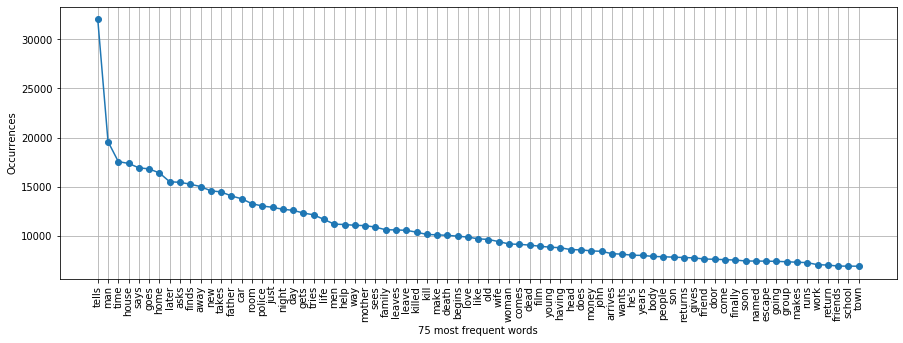

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 5))
plt.grid()
plt.plot([x[0] for x in occurrences[:75]], [x[1] for x in occurrences[:75]], marker='o')
plt.xticks(rotation=90)
plt.xlabel('75 most frequent words')
plt.ylabel('Occurrences')
plt.show()

## Vocabolario da 10000 parole

In [33]:
n_words = 10000

vocabulary = [occurrences[x][0] for x in range(n_words)]
vocabulary.sort()
vocabulary

['$10',
 '$100',
 '$20',
 '$200',
 '$50',
 '$500',
 "'the",
 '000',
 '100',
 '1000',
 '18th',
 '1944',
 '1945',
 '1950s',
 '1960s',
 '1968',
 '1969',
 '1970s',
 '1980s',
 '1985',
 '1992',
 '1999',
 '19th',
 '1st',
 '200',
 '2000',
 '2002',
 '20th',
 '2nd',
 '300',
 '4th',
 '500',
 '911',
 '[original',
 'aaron',
 'aback',
 'abandon',
 'abandoned',
 'abandoning',
 'abandons',
 'abbey',
 'abbott',
 'abby',
 'abdomen',
 'abduct',
 'abducted',
 'abduction',
 'abducts',
 'abe',
 'abel',
 'abigail',
 'abilities',
 'ability',
 'ablaze',
 'able',
 'aboard',
 'abortion',
 'abraham',
 'abroad',
 'abruptly',
 'absence',
 'absent',
 'absolutely',
 'absorbed',
 'abu',
 'abuse',
 'abused',
 'abuses',
 'abusing',
 'abusive',
 'academic',
 'academy',
 'accent',
 'accept',
 'acceptance',
 'accepted',
 'accepting',
 'accepts',
 'access',
 'accident',
 'accidental',
 'accidentally',
 'accidents',
 'accompanied',
 'accompanies',
 'accompany',
 'accompanying',
 'accomplice',
 'accomplices',
 'accomplish',
 

# Trasformazione dei dati nel formato adatto

In [34]:
import numpy as np
from pyspark.ml.linalg import Vectors

def dict_func(x, y):
    z = dict()
    z.update(x)
    z.update(y)
    return z

def featurisation(x):
    occ_vect = []
    plot_terms = x[1]
    for term in vocabulary:
        if term in plot_terms:
            occ_vect.append(plot_terms[term])
        else:
            occ_vect.append(0)
    return (x[0], Vectors.dense(occ_vect))

counted_rdd = joined_genres_df.rdd\
    .map(lambda x: (x[0], x[4]))\
    .map(lambda x: (x[0], x[1].replace(',', ' ').replace('.', ' ').replace('-', ' ').replace('"', ' ')\
    .replace('*', ' ').replace('(', ' ').replace(')', ' ').replace('=', ' ').lower()))\
    .map(lambda x: (x[0], x[1].split()))\
    .flatMap(lambda x: [str(x[0]) + '.' + str(item) for item in x[1]])\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)

id_words_rdd = counted_rdd.filter(lambda x: x[0].split('.')[1] in vocabulary)\
    .map(lambda x: (x[0].split('.')[0], [x[0].split('.')[1], x[1]]))

counted_rdd = joined_genres_df.rdd\
    .map(lambda x: (x[0], x[4]))\
    .map(lambda x: (x[0], x[1].replace(',', ' ').replace('.', ' ').replace('-', ' ').replace('"', ' ')\
    .replace('*', ' ').replace('(', ' ').replace(')', ' ').replace('=', ' ').lower()))\
    .map(lambda x: (x[0], x[1].split()))\
    .flatMap(lambda x: [str(x[0]) + '.' + str(item) for item in x[1]])\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)

features_rdd = counted_rdd.filter(lambda x: x[0].split('.')[1] in vocabulary)\
    .map(lambda x: (x[0].split('.')[0], {x[0].split('.')[1]: x[1]}))\
    .filter(lambda x: type(x[1]) is dict and type(x) is not None)\
    .reduceByKey(dict_func).map(featurisation)

spark = SparkSession.builder.appName('Words DF').getOrCreate()
vocab_words_df = spark.createDataFrame(features_rdd, ['feat_id', 'features'])
vocab_words_df.show()

+-------+--------------------+
|feat_id|            features|
+-------+--------------------+
|  96288|[0.0,1.0,0.0,0.0,...|
|  11904|[0.0,0.0,0.0,0.0,...|
|  53419|[0.0,0.0,0.0,0.0,...|
|  77270|[0.0,0.0,0.0,0.0,...|
|  39495|[1.0,0.0,0.0,1.0,...|
| 116014|[0.0,0.0,0.0,0.0,...|
|  72886|[0.0,0.0,0.0,0.0,...|
|  94405|[0.0,0.0,0.0,0.0,...|
|  27214|[0.0,0.0,0.0,0.0,...|
|  62006|[0.0,0.0,0.0,0.0,...|
|  41530|[0.0,0.0,0.0,0.0,...|
|  52017|[0.0,0.0,0.0,0.0,...|
| 114047|[0.0,0.0,0.0,0.0,...|
|  67276|[1.0,0.0,2.0,0.0,...|
|  42367|[0.0,0.0,0.0,0.0,...|
|  52278|[0.0,0.0,0.0,0.0,...|
| 108346|[0.0,0.0,0.0,0.0,...|
|  43084|[0.0,0.0,0.0,0.0,...|
|  41587|[0.0,0.0,0.0,0.0,...|
| 106922|[0.0,0.0,0.0,0.0,...|
+-------+--------------------+
only showing top 20 rows



# Divisione tra training, test e validazione

In [35]:
type_df = vocab_words_df.join(joined_genres_df, vocab_words_df.feat_id == joined_genres_df.imdbId)\
    .select('label', 'type', 'features')

genres_list = type_df.select('label').distinct().rdd.map(lambda x: x[0]).collect()
new_genres = dict()
i = 0
for g in genres_list:
    new_genres[g] = i
    i = i + 1

training_data = type_df.filter(type_df.type == 'train').select('label', 'features')\
    .rdd.map(lambda x: (new_genres[x[0]], x[1]))
test_data = type_df.filter(type_df.type == 'test').select('label', 'features')\
    .rdd.map(lambda x: (new_genres[x[0]], x[1]))
validation_data = type_df.filter(type_df.type == 'val').select('label', 'features')\
    .rdd.map(lambda x: (new_genres[x[0]], x[1]))

training_data_df = spark.createDataFrame(training_data, ['label', 'features'])
test_data_df = spark.createDataFrame(test_data, ['label', 'features'])
validation_data_df = spark.createDataFrame(validation_data, ['label', 'features'])

# Test naive Bayes

In [36]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1.0, modelType='multinomial')
model = nb.fit(training_data_df)
predictions = model.transform(test_data_df)

n_observations = predictions.rdd.count()
right = predictions.rdd\
    .map(lambda x: x[0] - int(x[4]))\
    .filter(lambda x: x == 0)\
    .count()
accuracy = (right / n_observations) * 100
print('Accuracy:', accuracy)
predictions.show()

Accuracy: 27.27272727272727
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    7|[0.0,0.0,0.0,0.0,...|[-3565.5351141056...|[8.00980112273121...|       7.0|
|   15|[0.0,0.0,0.0,0.0,...|[-763.30291792594...|[3.12941740191600...|       7.0|
|   15|[0.0,0.0,0.0,0.0,...|[-1560.7218898154...|[5.50677323834745...|      15.0|
|   15|[0.0,0.0,0.0,0.0,...|[-1020.8107146949...|[2.83212627222691...|       9.0|
|   15|[0.0,0.0,0.0,0.0,...|[-33904.070452578...|[0.0,0.0,0.0,0.0,...|       7.0|
|    1|[0.0,0.0,0.0,0.0,...|[-4458.8110155047...|[5.60110683390234...|       7.0|
|    8|[3.0,0.0,0.0,0.0,...|[-2665.7517643968...|[1.62353926793915...|       7.0|
|   15|[0.0,0.0,0.0,0.0,...|[-1679.9599393277...|[1.99366775202130...|      15.0|
|    2|[0.0,0.0,0.0,0.0,...|[-1764.2668464418...|[1.13192666631400...|

# Test OvA logistic regression

In [37]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
ovr = OneVsRest(classifier=lr)
ovr_model = ovr.fit(training_data_df)
predictions = ovr_model.transform(test_data_df)
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
predictions.show()

Test Error = 0.757576
+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    7|[0.0,0.0,0.0,0.0,...|       7.0|
|   15|[0.0,0.0,0.0,0.0,...|       7.0|
|   15|[0.0,0.0,0.0,0.0,...|      15.0|
|   15|[0.0,0.0,0.0,0.0,...|       9.0|
|   15|[0.0,0.0,0.0,0.0,...|       7.0|
|    1|[0.0,0.0,0.0,0.0,...|      16.0|
|    8|[3.0,0.0,0.0,0.0,...|       7.0|
|   15|[0.0,0.0,0.0,0.0,...|      15.0|
|    2|[0.0,0.0,0.0,0.0,...|       7.0|
|    7|[0.0,0.0,0.0,0.0,...|       7.0|
|   15|[0.0,0.0,0.0,0.0,...|      15.0|
|    7|[0.0,0.0,0.0,0.0,...|       7.0|
|   15|[0.0,0.0,0.0,0.0,...|       7.0|
|    3|[0.0,0.0,0.0,0.0,...|       7.0|
|    1|[0.0,0.0,0.0,0.0,...|       7.0|
|    1|[0.0,0.0,0.0,0.0,...|       7.0|
|    3|[0.0,0.0,0.0,0.0,...|       1.0|
|    3|[0.0,0.0,0.0,0.0,...|       7.0|
|   15|[0.0,0.0,0.0,0.0,...|       4.0|
|    8|[0.0,0.0,0.0,0.0,...|       7.0|
+-----+--------------------+----------+
only showing top 2

# Fine

In [38]:
sc.stop()